In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
import sys
import time
DATA_PATH = '../data/'
INPUT_PATH = '../data/input/'
SUBMIT_PATH = '../data/submit/'

In [2]:
%%time
train = pd.read_csv(DATA_PATH + 'train.csv', parse_dates=['timestamp'])  # 2016-01-01 ： 2016-12-31 20216100
train = train.query('not (building_id <= 104 & meter == 0 & timestamp <= "2016-05-20")')# 19869988 # 去除异常数据
test = pd.read_csv(DATA_PATH + 'test.csv', parse_dates=['timestamp'])  # 2017-01-01 ：2018-12-31  41697600
building_metadata = pd.read_csv(DATA_PATH + 'building_metadata.csv')
weather_train = pd.read_csv(DATA_PATH + 'weather_train.csv', parse_dates=['timestamp'])
weather_test = pd.read_csv(DATA_PATH + 'weather_test.csv', parse_dates=['timestamp'])

Wall time: 2min 6s


In [10]:
weather_train['wind_direction'].unique()

array([  0.,  70., 250., 210., 290., 230., 200., 180., 220., 270., 300.,
       360.,  20.,  30.,  10., 350.,  60., 340., 330., 110., 320., 310.,
        50.,  40.,  nan,  80.,  90., 100., 120., 160., 130., 140., 190.,
       170., 240., 280., 150., 260., 174., 176.,  84., 198., 196., 202.])

In [7]:
weather_train['dd'] = 1.2345678
weather_train['dd'] = weather_train['dd'].round(4)
weather_train.head()

,site_id,timestamp,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed,dd
0,0,2016-01-01 00:00:00,25.0,6.0,20.0,NaN,1019.7,0.0,0.0,1.2346
1,0,2016-01-01 01:00:00,24.4,NaN,21.1,-1.0,1020.2,70.0,1.5,1.2346
2,0,2016-01-01 02:00:00,22.8,2.0,21.1,0.0,1020.2,0.0,0.0,1.2346
3,0,2016-01-01 03:00:00,21.1,2.0,20.6,0.0,1020.1,0.0,0.0,1.2346
4,0,2016-01-01 04:00:00,20.0,2.0,20.0,-1.0,1020.0,250.0,2.6,1.2346


In [3]:
#对齐时间戳
weather = pd.concat([weather_train,weather_test],ignore_index=True)
weather_key = ['site_id', 'timestamp']
temp_skeleton = weather[weather_key + ['air_temperature']].drop_duplicates(subset=weather_key).sort_values(by=weather_key).copy()
temp_skeleton['temp_rank'] = temp_skeleton.groupby(['site_id', temp_skeleton.timestamp.dt.date])['air_temperature'].rank('average')
df_2d = temp_skeleton.groupby(['site_id', temp_skeleton.timestamp.dt.hour])['temp_rank'].mean().unstack(level=1)

#Subtract the columnID of temperature peak by 14, getting the timestamp alignment gap.
# 获取每个地区温度最高的时间点,假设最高温度出现在当地14点，进行时间点的对齐
site_ids_offsets = pd.Series(df_2d.values.argmax(axis=1) - 14)
site_ids_offsets.index.name = 'site_id'

def timestamp_align(df):
    df['offset'] = df.site_id.map(site_ids_offsets)
    df['timestamp_aligned'] = (df.timestamp - pd.to_timedelta(df.offset, unit='H'))
    df['timestamp'] = df['timestamp_aligned']
    del df['timestamp_aligned']
    return df
weather_train = timestamp_align(weather_train)
weather_test = timestamp_align(weather_test)
weather_train.head()

,site_id,timestamp,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed,offset
0,0,2015-12-31 19:00:00,25.0,6.0,20.0,NaN,1019.7,0.0,0.0,5
1,0,2015-12-31 20:00:00,24.4,NaN,21.1,-1.0,1020.2,70.0,1.5,5
2,0,2015-12-31 21:00:00,22.8,2.0,21.1,0.0,1020.2,0.0,0.0,5
3,0,2015-12-31 22:00:00,21.1,2.0,20.6,0.0,1020.1,0.0,0.0,5
4,0,2015-12-31 23:00:00,20.0,2.0,20.0,-1.0,1020.0,250.0,2.6,5


In [24]:
def timestamp_p(df):
    df['year'] = df['timestamp'].dt.year
    df['year'] = df['year'].map({2015:0, 2016:1, 2017:2, 2018:3}).astype(np.int8)
    df['date'] = df['timestamp'].dt.date
    df['hour'] = df['timestamp'].dt.hour.astype(np.int8)
    df['month'] = df['timestamp'].dt.month.astype(np.int8)
    df['dayofweek'] = df['timestamp'].dt.dayofweek.astype(np.int8)
    return df
weather_train = timestamp_p(weather_train)
# weather_test = timestamp_p(weather_test)
# del weather 
# del df_2d
# del temp_skeleton
# del site_ids_offsets
# weather_train.head()
weather_train.head(5)

,site_id,timestamp,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed,offset,year,date,hour,weekend,month,dayofweek
0,0,2015-12-31 19:00:00,25.0,6.0,20.0,NaN,1019.7,0.0,0.0,5,0,2015-12-31,19,3,12,3
1,0,2015-12-31 20:00:00,24.4,NaN,21.1,-1.0,1020.2,70.0,1.5,5,0,2015-12-31,20,3,12,3
2,0,2015-12-31 21:00:00,22.8,2.0,21.1,0.0,1020.2,0.0,0.0,5,0,2015-12-31,21,3,12,3
3,0,2015-12-31 22:00:00,21.1,2.0,20.6,0.0,1020.1,0.0,0.0,5,0,2015-12-31,22,3,12,3
4,0,2015-12-31 23:00:00,20.0,2.0,20.0,-1.0,1020.0,250.0,2.6,5,0,2015-12-31,23,3,12,3


In [22]:

print(weather_train['dayofweek'].unique())
print(weather_train['weekend'].unique())

weather_train.isna().sum()

[3 4 5 6 0 1 2]
[3 4 5 6 0 1 2]


site_id                   0
timestamp                 0
air_temperature          55
cloud_coverage        69173
dew_temperature         113
precip_depth_1_hr     50289
sea_level_pressure    10618
wind_direction         6268
wind_speed              304
offset                    0
year                      0
date                      0
hour                      0
weekend                   0
month                     0
dayofweek                 0
dtype: int64

In [17]:
weather = pd.concat([weather_train,weather_test],ignore_index=True)
weather_key = ['site_id', 'timestamp']
temp_skeleton = weather_test[weather_key + ['air_temperature']].drop_duplicates(subset=weather_key).sort_values(by=weather_key).copy()
temp_skeleton.shape

c:\python37\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """Entry point for launching an IPython kernel.


(277243, 3)

In [16]:
weather_test.shape + weather_train.shape
277243+139773


417016

In [12]:
weather_train['temp_rank'] = weather_train.groupby(['site_id', 'date'])['air_temperature'].rank('average')
weather_train.head()

,site_id,timestamp,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed,date,hour,temp_rank
0,0,2016-01-01 00:00:00,25.0,6.0,20.0,NaN,1019.7,0.0,0.0,2016-01-01,0,16.0
1,0,2016-01-01 01:00:00,24.4,NaN,21.1,-1.0,1020.2,70.0,1.5,2016-01-01,1,15.0
2,0,2016-01-01 02:00:00,22.8,2.0,21.1,0.0,1020.2,0.0,0.0,2016-01-01,2,13.0
3,0,2016-01-01 03:00:00,21.1,2.0,20.6,0.0,1020.1,0.0,0.0,2016-01-01,3,9.0
4,0,2016-01-01 04:00:00,20.0,2.0,20.0,-1.0,1020.0,250.0,2.6,2016-01-01,4,3.5


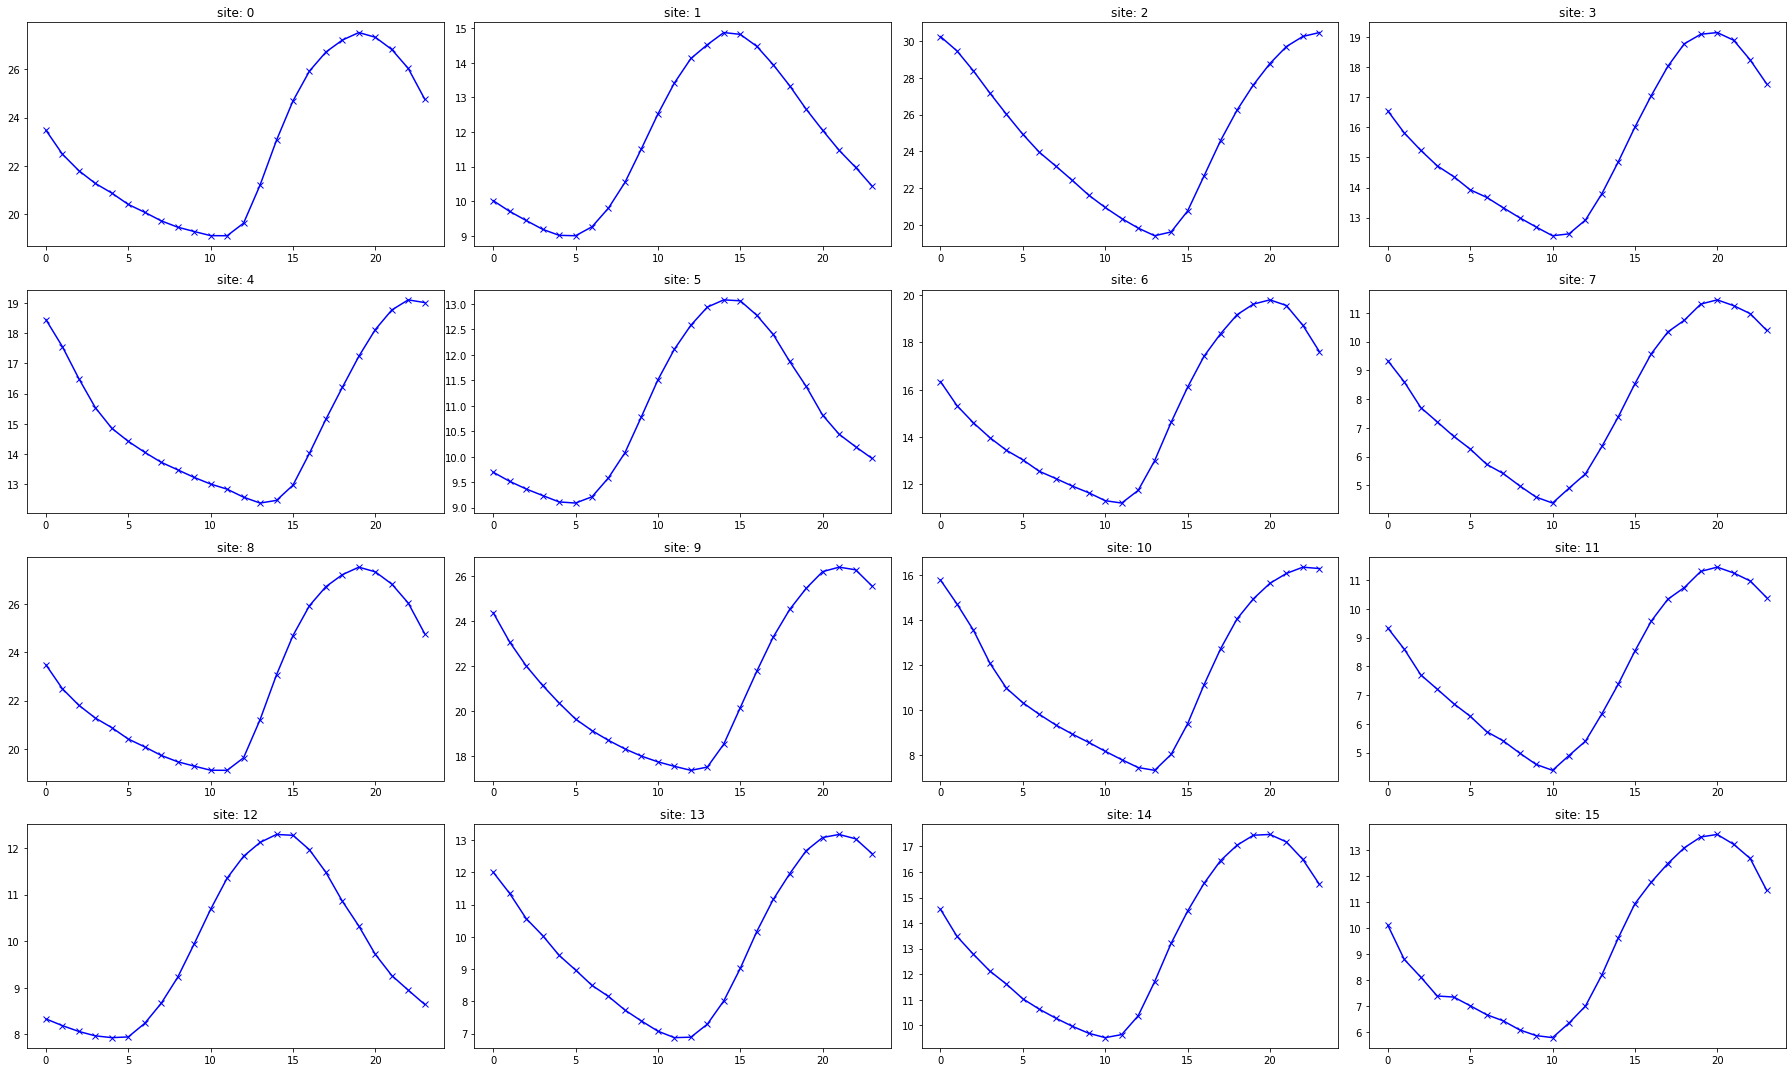

In [10]:
weather_data_to_plot = weather_train.copy()
weather_data_to_plot["hour"] = weather_train["timestamp"].dt.hour
count = 1
plt.figure(figsize=(25, 15))
for site_id, data_by_site in weather_data_to_plot.groupby('site_id'):
    by_site_by_hour = data_by_site.groupby('hour').mean()
    ax = plt.subplot(4, 4, count)
    plt.plot(by_site_by_hour.index,by_site_by_hour['air_temperature'],'xb-')
    ax.set_title('site: '+str(site_id))
    count += 1
plt.tight_layout()
plt.show()
#不一样的地区，温度的峰值在不同的时间点，证明了这个标记的时间不是当地的时间

In [23]:
#train['timestamp'] = pd.to_datetime(train['timestamp'], unit='s')
train['date'] = train['timestamp'].dt.date
train['date'].head()

AttributeError: Can only use .dt accessor with datetimelike values

(8784, 4)
(8784, 4)
(8784, 4)


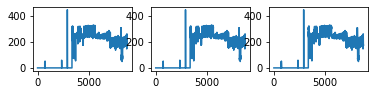

In [19]:
import matplotlib.pyplot as plt

j = 1
for i in train['building_id'].unique()[0:3]:
    plt_data = train[train['building_id']==0]
    plt_data.sort_values(by='timestamp')
    print(plt_data.shape)
    #plt.figure()
    plt.subplot(33*10+j)
    j = j+1
    plt.plot(range(plt_data.shape[0]), plt_data['meter_reading'])
plt.show()

In [ ]:
plt.figure()


In [14]:
train['year'] = train['timestamp'].apply(lambda x: x[0:4]).astype(int)
train['month'] = train['timestamp'].apply(lambda x: x[5:7]).astype(int)
train['date'] = train['timestamp'].apply(lambda x: x[8:10]).astype(int)
train['hour'] = train['timestamp'].apply(lambda x: x[11:13]).astype(int)
train['month_date'] = train['timestamp'].apply(lambda x: x[5:10])
test['year'] = test['timestamp'].apply(lambda x: x[0:4]).astype(int)
test['month'] = test['timestamp'].apply(lambda x: x[5:7]).astype(int)
test['date'] = test['timestamp'].apply(lambda x: x[8:10]).astype(int)
test['hour'] = test['timestamp'].apply(lambda x: x[11:13]).astype(int)
test['month_date'] = test['timestamp'].apply(lambda x: x[5:10])


print(test.info())
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41697600 entries, 0 to 41697599
Data columns (total 11 columns):
row_id         int64
building_id    int64
meter          int64
timestamp      object
time_ymd       object
time_hour      object
year           int32
month          int32
date           int32
hour           int32
month_date     object
dtypes: int32(4), int64(3), object(4)
memory usage: 2.8+ GB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20216100 entries, 0 to 20216099
Data columns (total 11 columns):
building_id      int64
meter            int64
timestamp        object
meter_reading    float64
time_ymd         object
time_hour        object
year             int32
month            int32
date             int32
hour             int32
month_date       object
dtypes: float64(1), int32(4), int64(2), object(4)
memory usage: 1.4+ GB


In [15]:
building_metadata = pd.read_csv(DATA_PATH + 'building_metadata.csv')
weather_train = pd.read_csv(DATA_PATH + 'weather_train.csv')
weather_test = pd.read_csv(DATA_PATH + 'weather_test.csv')

In [28]:
building_metadata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1449 entries, 0 to 1448
Data columns (total 6 columns):
site_id        1449 non-null int64
building_id    1449 non-null int64
primary_use    1449 non-null object
square_feet    1449 non-null int64
year_built     675 non-null float64
floor_count    355 non-null float64
dtypes: float64(2), int64(3), object(1)
memory usage: 68.0+ KB


In [29]:
weather_train.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 139773 entries, 0 to 139772
Data columns (total 9 columns):
site_id               139773 non-null int64
timestamp             139773 non-null object
air_temperature       139718 non-null float64
cloud_coverage        70600 non-null float64
dew_temperature       139660 non-null float64
precip_depth_1_hr     89484 non-null float64
sea_level_pressure    129155 non-null float64
wind_direction        133505 non-null float64
wind_speed            139469 non-null float64
dtypes: float64(7), int64(1), object(1)
memory usage: 9.6+ MB


In [36]:
weather_train['year'] = weather_train['timestamp'].apply(lambda x: x[0:4]).astype(int)
weather_train['month'] = weather_train['timestamp'].apply(lambda x: x[5:7]).astype(int)
weather_train['date'] = weather_train['timestamp'].apply(lambda x: x[8:10]).astype(int)
weather_train['hour'] = weather_train['timestamp'].apply(lambda x: x[11:13]).astype(int)
weather_train['month_date'] = weather_train['timestamp'].apply(lambda x: x[5:10])

weather_test['year'] = weather_test['timestamp'].apply(lambda x: x[0:4]).astype(int)
weather_test['month'] = weather_test['timestamp'].apply(lambda x: x[5:7]).astype(int)
weather_test['date'] = weather_test['timestamp'].apply(lambda x: x[8:10]).astype(int)
weather_test['hour'] = weather_test['timestamp'].apply(lambda x: x[11:13]).astype(int)
weather_test['month_date'] = weather_test['timestamp'].apply(lambda x: x[5:10])
weather_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 277243 entries, 0 to 277242
Data columns (total 14 columns):
site_id               277243 non-null int64
timestamp             277243 non-null object
air_temperature       277139 non-null float64
cloud_coverage        136795 non-null float64
dew_temperature       276916 non-null float64
precip_depth_1_hr     181655 non-null float64
sea_level_pressure    255978 non-null float64
wind_direction        264873 non-null float64
wind_speed            276783 non-null float64
year                  277243 non-null int32
month                 277243 non-null int32
date                  277243 non-null int32
hour                  277243 non-null int32
month_date            277243 non-null object
dtypes: float64(7), int32(4), int64(1), object(2)
memory usage: 25.4+ MB


In [37]:
print(train.shape)
print(test.shape)
train= train.merge(building_metadata, how='left', on=['building_id'])
test= test.merge(building_metadata, how='left', on=['building_id'])
print(train.shape)
print(test.shape)

train= train.merge(weather_train, how='left', on=['site_id','year','month','date','hour'])
test= test.merge(weather_test, how='left', on=['site_id','year','month','date','hour'])
print(train.shape)
print(test.shape)

(20216100, 11)
(41697600, 11)
(20216100, 16)
(41697600, 16)
(20216100, 25)
(41697600, 25)


In [39]:
test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 41697600 entries, 0 to 41697599
Data columns (total 25 columns):
row_id                int64
building_id           int64
meter                 int64
timestamp_x           object
time_ymd              object
time_hour             object
year                  int32
month                 int32
date                  int32
hour                  int32
month_date_x          object
site_id               int64
primary_use           object
square_feet           int64
year_built            float64
floor_count           float64
timestamp_y           object
air_temperature       float64
cloud_coverage        float64
dew_temperature       float64
precip_depth_1_hr     float64
sea_level_pressure    float64
wind_direction        float64
wind_speed            float64
month_date_y          object
dtypes: float64(9), int32(4), int64(5), object(7)
memory usage: 7.5+ GB


In [2]:
INPUT_PATH = '../data/input/'

train = pd.read_pickle(INPUT_PATH + 'train.pk')
test = pd.read_pickle(INPUT_PATH + 'test.pk')

In [7]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20216100 entries, 0 to 20216099
Data columns (total 20 columns):
building_id           int64
meter                 int64
meter_reading         float64
year                  int32
month                 int32
date                  int32
hour                  int32
month_date            object
site_id               int64
primary_use           object
square_feet           int64
year_built            float64
floor_count           float64
air_temperature       float64
cloud_coverage        float64
dew_temperature       float64
precip_depth_1_hr     float64
sea_level_pressure    float64
wind_direction        float64
wind_speed            float64
dtypes: float64(10), int32(4), int64(4), object(2)
memory usage: 2.9+ GB


In [9]:
train['meter'].unique()
#train.info()

array([0, 3, 1, 2], dtype=int64)